# **Enhancing Object Detection in YOLOS-Small through Advanced LoRA Methods**


## **1. Setting Up the Environment**

In [ ]:
# Install necessary libraries
!pip install torch torchvision transformers datasets huggingface_hub peft loralib
!pip install -q bitsandbytes accelerate loralib
!pip install torchmetrics torchinfo
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install --upgrade datasets
!pip install --upgrade git+https://github.com/huggingface/peft.git
!pip install tqdm
!pip install transformers tensorboard datasets evaluate torch torchvision -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torch.nn.functional as F
from datasets import load_dataset, get_dataset_split_names
from transformers import (
    YolosForObjectDetection,
    AutoImageProcessor
)
from peft import get_peft_model, LoraConfig, AdaLoraConfig, LoHaConfig, LoKrConfig, PeftModel
from collections import Counter, defaultdict
from IPython.display import display

# Set random seed for reproducibility
SEED_GLOBAL = 42
random.seed(SEED_GLOBAL)
np.random.seed(SEED_GLOBAL)
torch.manual_seed(SEED_GLOBAL)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_GLOBAL)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
# Set device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## **2. Data Preparation**


### Load COCO Dataset

In [ ]:
# Get COCO datasets split
split_names = get_dataset_split_names("detection-datasets/coco")
print(f"coco split dataset: {split_names}")

# Load COCO Validation dataset - 4,952 images
dataset = load_dataset("detection-datasets/coco", streaming=True)
val_dataset = dataset["val"]

# Map category indices to labels
coco_metadata = load_dataset("detection-datasets/coco", split="train")  # Load metadata
coco_categories = coco_metadata.features["objects"].feature["category"].names
coco_categories = {index: x for index, x in enumerate(coco_categories, start=0)}
coco_label2id = {v: k for k, v in coco_categories.items()}
print(f"COCO {len(coco_categories)} categories mapping (label2id): {coco_categories}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

coco split dataset: ['train', 'val']


Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

(…)-00000-of-00040-67e35002d152155c.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

(…)-00001-of-00040-2c2b33b9504aa843.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

(…)-00002-of-00040-58e30306870b1de7.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00003-of-00040-a77e00648e423963.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00004-of-00040-1df1755d6f7c9b17.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00005-of-00040-29ccfc8f52cfc9cb.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

(…)-00006-of-00040-76f2d663d51dca0a.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

(…)-00007-of-00040-797508421c59b99d.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00008-of-00040-7ad10a6d6b442ef9.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00009-of-00040-edc6018bb7abeee3.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

(…)-00010-of-00040-068d922af9742c1a.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00011-of-00040-2cf010e9592da434.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

(…)-00012-of-00040-e26d7a054b1f8c7f.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00013-of-00040-00a967ab3e2568fd.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00014-of-00040-4f6a348405f3725f.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00015-of-00040-ae8972f628750cea.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00016-of-00040-377112973594380c.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

(…)-00017-of-00040-e2f542f29ca61356.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00018-of-00040-3650ae2c12a832eb.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00019-of-00040-f262669c6302eb2d.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00020-of-00040-d2763ce5e7ab097f.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

(…)-00021-of-00040-fb98d35ab4e6ca66.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00022-of-00040-c4f90a7435af5217.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00023-of-00040-31db5fa16e24d32d.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00024-of-00040-786ee9123ad04e52.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00025-of-00040-369c096f8c7d7ab6.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00026-of-00040-709cf1a409a2698c.parquet:   0%|          | 0.00/470M [00:00<?, ?B/s]

(…)-00027-of-00040-c99041dbf751516d.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00028-of-00040-5e11f3d596cb0db3.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00029-of-00040-988997614786b5b4.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00030-of-00040-497df2d4082da46b.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00031-of-00040-541a6ccf9f21093e.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

(…)-00032-of-00040-659aee4f72e8f525.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00033-of-00040-0074f368f6733826.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

(…)-00034-of-00040-edcd109018ecaf95.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00035-of-00040-c8fd4fb1bb93114d.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

(…)-00036-of-00040-5d6d294fbed2af1b.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

(…)-00037-of-00040-cb1276b8824445cd.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00038-of-00040-15a5fd14791741e4.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00039-of-00040-f1a97fa690638b05.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

(…)-00000-of-00002-c4f2e391ee4aba11.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

(…)-00001-of-00002-7af5414a3b178949.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/117266 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/4952 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

COCO 80 categories mapping (label2id): {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'k

### Load YOLOS-Small Pre-trained Model

In [ ]:
model_name = "hustvl/yolos-small"
original_model = YolosForObjectDetection.from_pretrained(model_name).to(device)
processor = AutoImageProcessor.from_pretrained(model_name)

# Load YOLOS categories
yolos_categories = original_model.config.id2label
print(f"YOLOS {original_model.config.num_labels} categories mapping (label2id): {yolos_categories}")


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


YOLOS 91 categories mapping (label2id): {0: 'N/A', 1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 12: 'N/A', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'N/A', 27: 'backpack', 28: 'umbrella', 29: 'N/A', 30: 'N/A', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 45: 'N/A', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 66: 'N/A', 67: 'dining t

## **3. Data Understanding**

### YOLOS-Small Architechture

In [ ]:
summary(original_model)

Layer (type:depth-idx)                                       Param #
YolosForObjectDetection                                      --
├─YolosModel: 1-1                                            --
│    └─YolosEmbeddings: 2-1                                  741,120
│    │    └─YolosPatchEmbeddings: 3-1                        295,296
│    │    └─Dropout: 3-2                                     --
│    │    └─InterpolateInitialPositionEmbeddings: 3-3        --
│    └─YolosEncoder: 2-2                                     7,725,696
│    │    └─ModuleList: 3-4                                  21,293,568
│    │    └─InterpolateMidPositionEmbeddings: 3-5            --
│    └─LayerNorm: 2-3                                        768
├─YolosMLPPredictionHead: 1-2                                --
│    └─ModuleList: 2-4                                       --
│    │    └─Linear: 3-6                                      147,840
│    │    └─Linear: 3-7                                      147,840

### Processor Configuration

In [ ]:
processor

YolosImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "YolosImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

### Data Structure

In [ ]:
# Checking dataset structure using first image
print("\nValidation dataset structure:")
val_example = next(iter(val_dataset))
val_image = val_example["image"]  # Already a PIL.Image object
print(f"Original Validation Image Size: {val_image.size}")
print("Example keys:", val_example.keys())
print("Type of image:", type(val_example["image"]))

# Checking the structure of objects
if "objects" in val_example:
    validation_objects = val_example["objects"]
    print(f"Validation objects structure: {type(validation_objects)}")
    if isinstance(validation_objects, dict):
        print(f"Keys in objects: {list(validation_objects.keys())}")
        print(f"bbox_id:{validation_objects['bbox_id']}")
        print(f"category:{validation_objects['category']}")
        print(f"bbox:{validation_objects['bbox']}")
        print(f"area:{validation_objects['area']}")
    elif isinstance(validation_objects, list):
        print(f"First object: {validation_objects[0]}")



Validation dataset structure:
Original Validation Image Size: (640, 426)
Example keys: dict_keys(['image_id', 'image', 'width', 'height', 'objects'])
Type of image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Validation objects structure: <class 'dict'>
Keys in objects: ['bbox_id', 'category', 'bbox', 'area']
bbox_id:[26547, 34646, 35802, 103487, 104368, 105328, 110334, 230831, 233201, 1640282, 1647285, 1648594, 1654394, 1666628, 1667817, 1669970, 1941808, 2146194, 2146548, 2204286]
category:[58, 62, 62, 56, 56, 56, 56, 0, 0, 68, 72, 73, 73, 74, 75, 75, 56, 75, 75, 60]
bbox:[[236.98, 142.51, 261.68, 212.01], [7.03, 167.76, 156.35, 262.63], [557.21, 209.19, 638.5600000000001, 287.92], [358.98, 218.05, 414.98, 320.88], [290.69, 218.0, 352.52, 316.48], [413.2, 223.01, 443.37, 304.37], [317.4, 219.24, 338.97999999999996, 230.83], [412.8, 157.61, 465.85, 295.62], [384.43, 172.21, 399.55, 207.95000000000002], [512.22, 205.75, 526.96, 221.72], [493.1, 174.34, 513.39, 282.65], [604.77, 305.89

### Categories Comparison between YOLOS and COCO

In [ ]:
# Null YOLOS categories
nulls = "Null YOLOS Categories: "
for k, v in yolos_categories.items():
    if v == "N/A":
        nulls += f"{k}, "
nulls = nulls.rstrip(", ")
print(nulls)

# Compare YOLOS and COCO categories
yolos_to_coco_mapping = {}
mismatched_categories = []
for yolos_id, yolos_label in yolos_categories.items():
    coco_match = None
    for coco_id, coco_label in coco_categories.items():
        if yolos_label.lower() == coco_label.lower():  # Compare by name
            coco_match = coco_id
            break
    if coco_match is not None:
        yolos_to_coco_mapping[yolos_id] = coco_match
    else:
        mismatched_categories.append((yolos_id, yolos_label))

# Print matched categories
print("\nMatched categories:")
for yolos_id, coco_id in yolos_to_coco_mapping.items():
    print(f"YOLOS ID {yolos_id}: {yolos_categories[yolos_id]} -> COCO ID {coco_id}: {coco_categories[coco_id]}")

# Print mismatched categories
print("\nMismatched categories:")
for yolos_id, yolos_label in mismatched_categories:
    print(f"YOLOS ID {yolos_id}: {yolos_label} (No match in COCO)")

# Summary of results
print("\nComparison summary:")
print(f"Total YOLOS categories: {len(yolos_categories)}")
print(f"Matched categories: {len(yolos_to_coco_mapping)}")
print(f"Mismatched categories: {len(mismatched_categories)}")
# Check if all categories in COCO can be detected by the model
coco_categories_set = set(coco_categories.values())
imagenet_categories_set = set(yolos_categories.values())
missing_categories = coco_categories_set - imagenet_categories_set
if len(missing_categories) == 0:
    print("YOLOS model can detect all COCO categories.")
else:
    print(f"YOLOS model cannot detect {len(missing_categories)} COCO categories.")

# Create a mapping between YOLOS category IDs and COCO category IDs for evaluation
yolos_to_coco_mapping = {yolos_id: yolos_to_coco_mapping.get(yolos_id, -1) for yolos_id in yolos_categories.keys()}
print(f"YOLOS to COCO categories mapping: {yolos_to_coco_mapping}")
# Create a reverse mapping to go from COCO category IDs back to YOLOS category IDs
coco_to_yolos_mapping = {coco_id: yolos_id for yolos_id, coco_id in yolos_to_coco_mapping.items() if coco_id != -1}
print(f"COCO to YOLOS categories mapping: {coco_to_yolos_mapping}")

Null YOLOS Categories: 0, 12, 26, 29, 30, 45, 66, 68, 69, 71, 83

Matched categories:
YOLOS ID 1: person -> COCO ID 0: person
YOLOS ID 2: bicycle -> COCO ID 1: bicycle
YOLOS ID 3: car -> COCO ID 2: car
YOLOS ID 4: motorcycle -> COCO ID 3: motorcycle
YOLOS ID 5: airplane -> COCO ID 4: airplane
YOLOS ID 6: bus -> COCO ID 5: bus
YOLOS ID 7: train -> COCO ID 6: train
YOLOS ID 8: truck -> COCO ID 7: truck
YOLOS ID 9: boat -> COCO ID 8: boat
YOLOS ID 10: traffic light -> COCO ID 9: traffic light
YOLOS ID 11: fire hydrant -> COCO ID 10: fire hydrant
YOLOS ID 13: stop sign -> COCO ID 11: stop sign
YOLOS ID 14: parking meter -> COCO ID 12: parking meter
YOLOS ID 15: bench -> COCO ID 13: bench
YOLOS ID 16: bird -> COCO ID 14: bird
YOLOS ID 17: cat -> COCO ID 15: cat
YOLOS ID 18: dog -> COCO ID 16: dog
YOLOS ID 19: horse -> COCO ID 17: horse
YOLOS ID 20: sheep -> COCO ID 18: sheep
YOLOS ID 21: cow -> COCO ID 19: cow
YOLOS ID 22: elephant -> COCO ID 20: elephant
YOLOS ID 23: bear -> COCO ID 21: be

### Sample Visualization

In [ ]:
def visualize_sample(image, objects, title="Sample Visualization", font_size=16):
    if isinstance(image, np.ndarray) and image.ndim == 2: # Handle 2D tensor images
        image = Image.fromarray(np.uint8(image)).convert("RGB")
    elif isinstance(image, Image.Image): # Handle grayscale images
        image = image.convert("RGB")
    else:
        print(f"Unsupported image format. Skipping.")
        return

    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()
    if isinstance(objects, dict): # ensure the required keys
        bbox_list = objects.get("bbox", [])
        category_list = objects.get("category", [])
        if len(bbox_list) != len(category_list):
            print("Mismatch between bbox and category lengths.")
            return

    # Draw Bounding Boxes
    for category_id, box in zip(category_list, bbox_list):
        label = coco_categories[category_id]
        draw.rectangle(box, outline="red", width=2)
        draw.text((box[0], box[1] - font_size), label, fill="red", font=font)
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


Validation Sample Image Size: (640, 426)
Validation Sample Annotations: {'bbox_id': [26547, 34646, 35802, 103487, 104368, 105328, 110334, 230831, 233201, 1640282, 1647285, 1648594, 1654394, 1666628, 1667817, 1669970, 1941808, 2146194, 2146548, 2204286], 'category': [58, 62, 62, 56, 56, 56, 56, 0, 0, 68, 72, 73, 73, 74, 75, 75, 56, 75, 75, 60], 'bbox': [[236.98, 142.51, 261.68, 212.01], [7.03, 167.76, 156.35, 262.63], [557.21, 209.19, 638.5600000000001, 287.92], [358.98, 218.05, 414.98, 320.88], [290.69, 218.0, 352.52, 316.48], [413.2, 223.01, 443.37, 304.37], [317.4, 219.24, 338.97999999999996, 230.83], [412.8, 157.61, 465.85, 295.62], [384.43, 172.21, 399.55, 207.95000000000002], [512.22, 205.75, 526.96, 221.72], [493.1, 174.34, 513.39, 282.65], [604.77, 305.89, 619.11, 351.59999999999997], [613.24, 308.24, 626.12, 354.68], [447.77, 121.12, 461.74, 143.0], [549.06, 309.43, 585.7399999999999, 399.1], [350.76, 208.84, 362.13, 231.39000000000001], [412.25, 219.02, 421.88, 231.54000000000

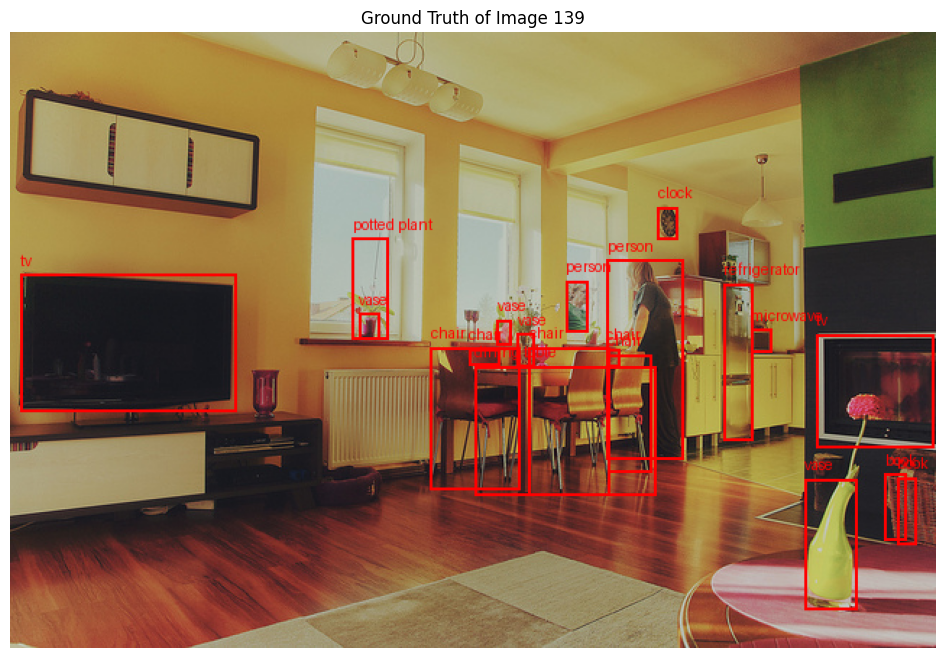

In [ ]:
# Visualize first sample
val_image = val_example["image"]
val_image_annotations = val_example["objects"]
print(f"Validation Sample Image Size: {val_image.size}")
print(f"Validation Sample Annotations: {val_image_annotations}")
visualize_sample(val_image, val_image_annotations, title=f"Ground Truth of Image {val_example['image_id']}")


## **4. Split COCO Validation dataset**

### Train and Test Split of COCO Validation dataset

In [ ]:
# shaffle dataset for splitting datasets
val_dataset = val_dataset.shuffle(seed=SEED_GLOBAL).shuffle(seed=SEED_GLOBAL).shuffle(seed=SEED_GLOBAL)

# Choose Train and Test smaples from COCO Validation dataset
train_full_dataset = val_dataset.skip(900).take(2100)
test_dataset = val_dataset.take(900)
train_full_count = sum(1 for _ in train_full_dataset)
test_count = sum(1 for _ in test_dataset)
print(f"Train (and validation) dataset size: {train_full_count}")
print(f"Test dataset size: {test_count}")


Train (and validation) dataset size: 2100
Test dataset size: 900


### Train and Test datasets structure

In [ ]:
# Train
print("\nTrain dataset structure:")
train_example = next(iter(train_full_dataset.shuffle(seed=SEED_GLOBAL)))
train_image = train_example["image"]
print(f"Original Train Image Size: {train_image.size}")
print("Example keys:", train_example.keys())
print("Type of image:", type(train_example["image"]))
if "objects" in train_example:
    train_objects = train_example["objects"]
    print(f"Train objects structure: {type(train_objects)}")
    print(f"Keys in objects: {list(train_objects.keys())}")
    print(f"bbox_id:{train_objects['bbox_id']}")
    print(f"category:{train_objects['category']}")
    print(f"bbox:{train_objects['bbox']}")
    print(f"area:{train_objects['area']}")

# Test
print("\nTest dataset structure:")
test_dataset = test_dataset
test_example = next(iter(test_dataset))
test_image = test_example["image"]
print(f"Original Validation Image Size: {test_image.size}")
print("Example keys:", test_example.keys())
print("Type of image:", type(test_example["image"]))
if "objects" in test_example:
    test_objects = test_example["objects"]
    print(f"Test objects structure: {type(test_objects)}")
    print(f"Keys in objects: {list(test_objects.keys())}")
    print(f"bbox_id:{test_objects['bbox_id']}")
    print(f"category:{test_objects['category']}")
    print(f"bbox:{test_objects['bbox']}")
    print(f"area:{test_objects['area']}")



Train dataset structure:
Original Train Image Size: (640, 480)
Example keys: dict_keys(['image_id', 'image', 'width', 'height', 'objects'])
Type of image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Train objects structure: <class 'dict'>
Keys in objects: ['bbox_id', 'category', 'bbox', 'area']
bbox_id:[595780, 596984, 2069400, 2069468]
category:[23, 23, 19, 19]
bbox:[[375.39, 170.24, 457.9, 378.49], [235.19, 142.4, 387.14, 400.63], [453.0, 218.61, 527.4300000000001, 263.73], [90.66, 239.1, 204.57999999999998, 304.46]]
area:[7247.408399999999, 17046.003600000004, 722.3113499999995, 3426.395449999999]

Test dataset structure:
Original Validation Image Size: (640, 427)
Example keys: dict_keys(['image_id', 'image', 'width', 'height', 'objects'])
Type of image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Test objects structure: <class 'dict'>
Keys in objects: ['bbox_id', 'category', 'bbox', 'area']
bbox_id:[582946, 584399, 585219, 585735, 585822, 585937]
category:[20, 20, 20, 20, 20, 20]


### Visualize Train and Test samples

Train Sample Image Size: (640, 480)
Train Sample Annotations: {'bbox_id': [595780, 596984, 2069400, 2069468], 'category': [23, 23, 19, 19], 'bbox': [[375.39, 170.24, 457.9, 378.49], [235.19, 142.4, 387.14, 400.63], [453.0, 218.61, 527.4300000000001, 263.73], [90.66, 239.1, 204.57999999999998, 304.46]], 'area': [7247.408399999999, 17046.003600000004, 722.3113499999995, 3426.395449999999]}


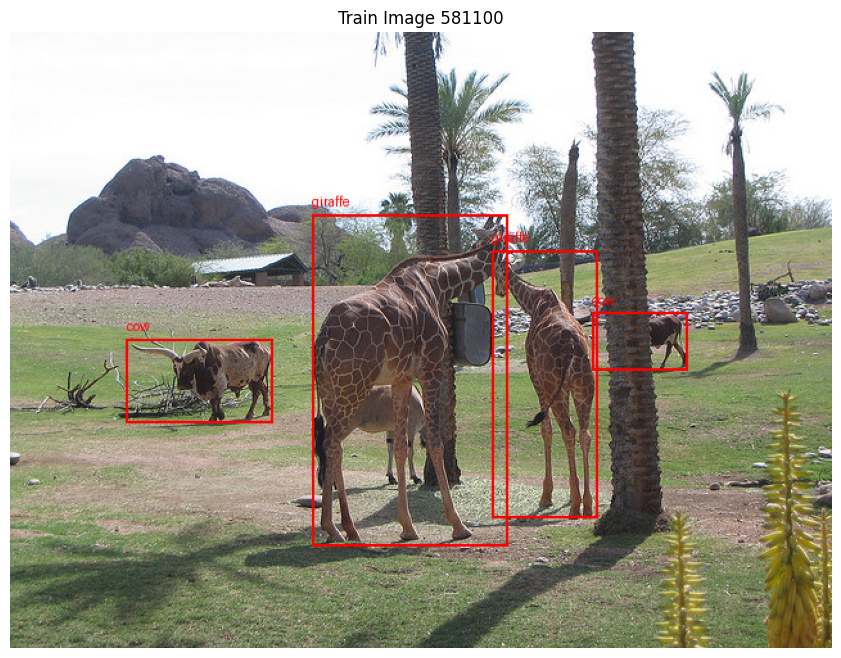

Test Sample Image Size: (640, 427)
Test Sample Annotations: {'bbox_id': [582946, 584399, 585219, 585735, 585822, 585937], 'category': [20, 20, 20, 20, 20, 20], 'bbox': [[161.8, 224.99, 312.11, 420.3], [307.48, 136.63, 568.69, 421.94], [3.8, 36.81, 299.7, 427.0], [260.25, 92.29, 423.14, 330.37], [419.32, 76.76, 640.0, 366.55], [419.59, 39.06, 640.0, 109.75]], 'area': [21142.318399999993, 56080.934049999996, 73129.31629999999, 8668.061650000001, 36205.77155, 4425.403350000001]}


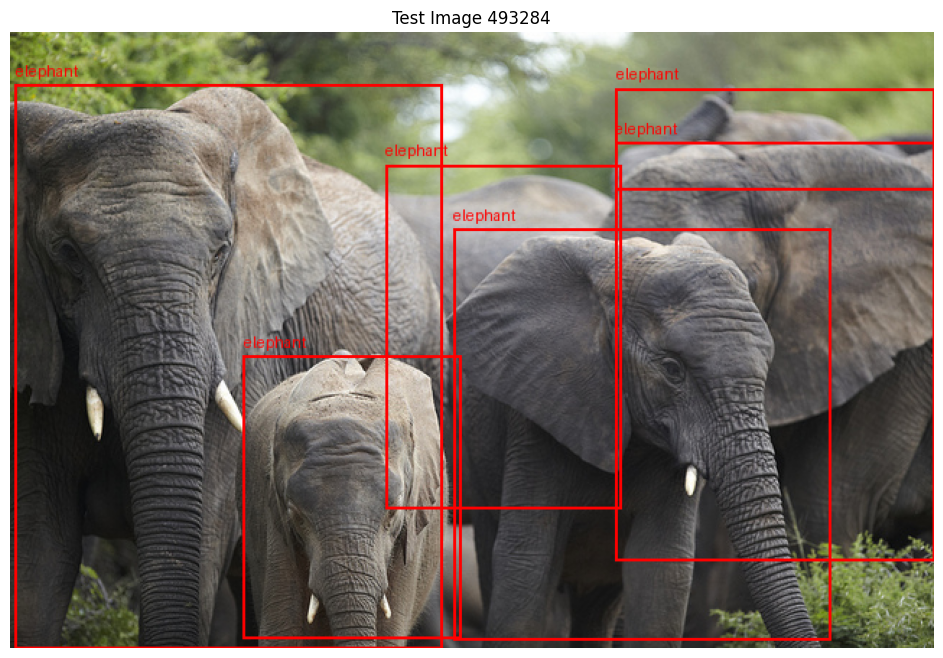

In [ ]:
# Train
train_image = train_example["image"]
train_image_annotations = train_example["objects"]
print(f"Train Sample Image Size: {train_image.size}")
print(f"Train Sample Annotations: {train_image_annotations}")
visualize_sample(train_image.copy(), train_image_annotations, title=f"Train Image {train_example['image_id']}")

# Test
test_image = test_example["image"]
test_image_annotations = test_example["objects"]
print(f"Test Sample Image Size: {test_image.size}")
print(f"Test Sample Annotations: {test_image_annotations}")
visualize_sample(test_image.copy(), test_image_annotations, title=f"Test Image {test_example['image_id']}")

### Split Train full dataset into Train and Validation datasets

In [ ]:
train_dataset = train_full_dataset.skip(630) # 70% train
train_val_dataset = train_full_dataset.take(630) # 30% validation
train_count = sum(1 for _ in train_dataset)
train_val_count = sum(1 for _ in train_val_dataset)
print(f"Train dataset size: {train_count}  ({int(train_count/train_full_count*100)}% train samples)")
print(f"Validation dataset size: {train_val_count}  ({int(train_val_count/train_full_count*100)}% train samples)")


Train dataset size: 1470  (70% train samples)
Validation dataset size: 630  (30% train samples)


### Ensuring Representation of All Categories

In [ ]:
def count_categories(dataset):
    category_counts = defaultdict(int)
    total_images = 0
    for sample in dataset:
        total_images += 1
        categories = sample["objects"]["category"]
        # Ensure each image is counted only once per category
        unique_categories = set(categories)
        for cat in unique_categories:
            category_counts[cat] += 1
    return category_counts, total_images

# Count for train, validation and test sets
train_category_counts, train_total = count_categories(train_dataset)
train_val_category_counts, train_val_total = count_categories(train_val_dataset)
test_category_counts, test_total = count_categories(test_dataset)

# Expected categories from COCO (0-79)
all_categories = set(range(80))

# Find missing categories
missing_train_categories = all_categories - set(train_category_counts.keys())
missing_train_val_categories = all_categories - set(train_val_category_counts.keys())
missing_test_categories = all_categories - set(test_category_counts.keys())

# Category Counts
# Train
print(f"Total Train Images: {train_total}")
print("Train Set Category Distribution:")
for category in sorted(all_categories):
    count = train_category_counts.get(category, 0)
    category_name = coco_categories[category]  # Get category name
    print(f"{category_name} (Category {category}): {count} images")
# Validation
print(f"\nTotal Train-Validation Images: {train_val_total}")
print("Train-Validation Set Category Distribution:")
for category in sorted(all_categories):
    count = train_val_category_counts.get(category, 0)
    category_name = coco_categories[category]  # Get category name
    print(f"{category_name} (Category {category}): {count} images")
# Test
print(f"\nTotal Test Images: {test_total}")
print("Test Set Category Distribution:")
for category in sorted(all_categories):
    count = test_category_counts.get(category, 0)
    category_name = coco_categories[category]  # Get category name
    print(f"{category_name} (Category {category}): {count} images")

# Missing Categories
# Train
if missing_train_categories:
    missing_names = [f"{coco_categories[cat]} ({cat})" for cat in sorted(missing_train_categories)]
    print(f"\nMissing categories in train set: {missing_names}")
else:
    print("\nAll categories are represented in the TRAIN set!")
# Validation
if missing_train_val_categories:
    missing_names = [f"{coco_categories[cat]} ({cat})" for cat in sorted(missing_train_val_categories)]
    print(f"\nMissing categories in validation set: {missing_names}")
else:
    print("\nAll categories are represented in the VALIDATION set!")
# Test
if missing_test_categories:
    missing_names = [f"{coco_categories[cat]} ({cat})" for cat in sorted(missing_test_categories)]
    print(f"\nMissing categories in test set: {missing_names}")
else:
    print("\nAll categories are represented in the TEST set!")

# Shuffle all datasets
train_dataset = train_dataset.shuffle(seed=SEED_GLOBAL)
train_val_dataset = train_val_dataset.shuffle(seed=SEED_GLOBAL)
test_dataset = test_dataset.shuffle(seed=SEED_GLOBAL)


Total Train Images: 1470
Train Set Category Distribution:
person (Category 0): 791 images
bicycle (Category 1): 45 images
car (Category 2): 147 images
motorcycle (Category 3): 42 images
airplane (Category 4): 26 images
bus (Category 5): 47 images
train (Category 6): 50 images
truck (Category 7): 72 images
boat (Category 8): 29 images
traffic light (Category 9): 59 images
fire hydrant (Category 10): 26 images
stop sign (Category 11): 23 images
parking meter (Category 12): 13 images
bench (Category 13): 69 images
bird (Category 14): 39 images
cat (Category 15): 53 images
dog (Category 16): 44 images
horse (Category 17): 44 images
sheep (Category 18): 25 images
cow (Category 19): 33 images
elephant (Category 20): 24 images
bear (Category 21): 17 images
zebra (Category 22): 30 images
giraffe (Category 23): 36 images
backpack (Category 24): 67 images
umbrella (Category 25): 55 images
handbag (Category 26): 80 images
tie (Category 27): 46 images
suitcase (Category 28): 28 images
frisbee (Cat